# Image segmentation

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lento234/ml-tutorials/blob/main/02-advanced/advanced.ipynb)

<span style="color:red;"> On the main menu, click Runtime and select **Change runtime type**. "GPU" as the hardware accelerator.</span>

In [21]:
!nvidia-smi

Sun Jan 10 23:22:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:0A:00.0  On |                  N/A |
| 32%   40C    P0    64W / 260W |   1593MiB / 10997MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


**TODO**:
- pix2pix
- Dataset: https://www.robots.ox.ac.uk/%7Evgg/data/pets/
- U-Net model


## Setup

Lightning is easy to install. Simply ```pip install pytorch-lightning```

In [22]:
!pip install pytorch-lightning --quiet

### Environment

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets

import pytorch_lightning as pl

import matplotlib.pyplot as plt
import numpy as np

In [24]:
pl.seed_everything(234)

234

### Hyper-parameters

In [5]:
batch_size = 32
num_workers = 4
num_epochs = 5
learning_rate = 0.001
momentum = 0.9

<a id='load'></a>
## 1. Load and pre-process data

- Define preprocessing algorithm
- Load training and test dataset

### 1.1 Define preprocessing algorithm

In [25]:
transform = transforms.Compose([
    transforms.ToTensor(), # convert data to pytorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize dataset for each channel
])

### 1.2 Load training and test dataset

In [26]:
# Download train and test dataset
train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, 
                                 download=True, transform=transform)

# Dataset sampler (shuffle, distributed loading)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                          shuffle=False, num_workers=num_workers)

print(f"num. examples: train = {len(train_dataset)}, test = {len(test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
num. examples: train = 50000, test = 10000


In [27]:
classes = np.array(['plane', 'car', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'])

num_classes = len(classes)

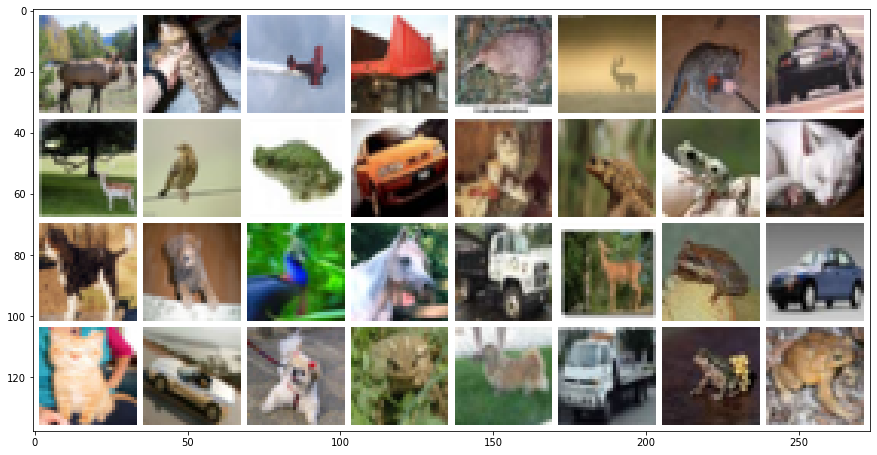

['deer' 'cat' 'plane' 'truck' 'bird' 'deer' 'cat' 'car' 'deer' 'bird'
 'frog' 'car' 'cat' 'frog' 'frog' 'cat' 'dog' 'dog' 'bird' 'horse' 'truck'
 'deer' 'frog' 'car' 'cat' 'car' 'dog' 'frog' 'dog' 'truck' 'frog' 'frog']


In [28]:
# Functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images, pad_value=1))
print(classes[labels])

<a id=define></a>
## 2. Define the CNN model **+ training step + loss + optimizer**

*TODO: network diagram*

In [29]:
class Net(pl.LightningModule):
    def __init__(self, **kwargs):
        super(Net, self).__init__()
        
        # save hyper-parameters
        self.save_hyperparameters()
        
        # Define network
        self.layer1 = nn.Sequential(nn.Conv2d(self.hparams.num_channels, 6, kernel_size=5),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 =  nn.Sequential(nn.Conv2d(6, 16, kernel_size=5),
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=2, stride=2),
                                     nn.Flatten())
        self.layer3 = nn.Sequential(nn.Linear(16 * 5 * 5, 120),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.Linear(120, 84),
                                    nn.ReLU())
        self.layer5 = nn.Linear(84, self.hparams.num_classes)
        
        self.example_input_array = torch.ones(1, self.hparams.num_channels, 32, 32)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x_train, y_train = batch
        y_pred = self(x_train) # Forward-pass
        loss = F.cross_entropy(y_pred, y_train) # loss
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True) # logging
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_test, y_test = batch
        y_pred = self(x_test)
        loss = F.cross_entropy(y_pred, y_test) # loss
        self.log('val_loss', loss)
        
    def test_step(self, batch, batch_idx):
        x_test, y_test = batch
        y_pred = self(x_test)
        loss = F.cross_entropy(y_pred, y_test)
        self.log('test_loss', loss)
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(),
                               lr=self.hparams.learning_rate,
                               momentum=self.hparams.momentum)
    


In [30]:
# Construct model
model = Net(num_channels=3,
            num_classes=num_classes,
            learning_rate=learning_rate,
            momentum=momentum)

<a id=trainer></a>
## 3. Setup the **trainer**

### 3.1 Define a logger

In [12]:
logger = pl.loggers.TensorBoardLogger(save_dir="lightning_logs", 
                                      name="CIFAR10",
                                      log_graph=True)

# Further loggers: https://pytorch-lightning.readthedocs.io/en/latest/logging.html
# Commet.ml, CSV, MLflow, Neptune, Tensorboard, TestTube, WandB

### 3.2 Callbacks

In [40]:
# Early stopping
early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(monitor='val_loss')

# checkpoint
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    save_top_k=3,
)


### 3.2 Initialize the trainer

In [43]:
# GPU trainer
trainer = pl.Trainer(
    gpus=1,
    max_epochs=num_epochs,
    logger=logger,
    callbacks=[early_stopping_callback, checkpoint_callback],
#     precision=16, # half-precision
)
# Further trainer options: https://pytorch-lightning.readthedocs.io/en/latest/trainer.html
# Callbacks, multi-gpu, distributed, tune lr and/or batch size, ...

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


<a id=train></a>
## 4. Train **and validate** the model on **train** and **test** dataset

In [44]:
trainer.fit(model, train_loader, test_loader)

/home/lento/lib/miniconda3/envs/ml-tutorials/lib/python3.8/site-packages/torch/jit/_trace.py:958: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=0.001, found 1 element(s) (out of 10) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 0.001953125 (-3.08203125 vs. -3.080078125), which occurred at index (0, 1).
  _check_trace(

  | Name   | Type       | Params | In sizes       | Out sizes     
------------------------------------------------------------------------
0 | layer1 | Sequential | 456    | [1, 3, 32, 32] | [1, 6, 14, 14]
1 | layer2 | Sequential | 2.4 K  | [1, 6, 14, 14] | [1, 400]      
2 | layer3 | Sequential | 48.1 K | [1, 400]       | [1, 120]      
3 | layer4 | Sequential | 10.2 K | [1, 120]       | [1, 84]       
4 | layer5 | Linear     | 850    | [1, 84]        | [1, 10]       
--------------------------------

Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

1

<a id=tensorboard></a>
## 5. Assess training with **tensorboard**

In [51]:
# Automatic logging
!ls lightning_logs/*

version_0


In [50]:
# Start tensorboard
%reload_ext tensorboard
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 23781), started 1:41:05 ago. (Use '!kill 23781' to kill it.)

<a id="validate"></a>
## 5. Test the model on **test** dataset

In [17]:
trainer.test(model, test_loader)

/home/lento/lib/miniconda3/envs/ml-tutorials/lib/python3.8/site-packages/torch/jit/_trace.py:958: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=0.001, found 3 element(s) (out of 10) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 0.001953125 (3.025390625 vs. 3.0234375), which occurred at index (0, 5).
  _check_trace(


Testing: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(2.0407, device='cuda:0')}
--------------------------------------------------------------------------------


[{'test_loss': 2.040663242340088}]

In [18]:
# images, labels = next(iter(test_loader))

# # predict
# prediction = model(images.to(device))
# prediction = prediction.cpu() # gpu -> cpu
# predicted_labels = torch.argmax(prediction, 1).detach()

# # print images
# imshow(torchvision.utils.make_grid(images))
# print("Ground truth:", classes[labels])
# print("Prediction  :", classes[predicted_labels])

### 5.2. Accuracy of the model on **test** dataset

In [19]:
# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in tqdm(test_loader, total=len(test_loader)):
#         prediction = model(images.to(device)).cpu()
#         predicted_labels = torch.argmax(prediction, 1)
#         total += predicted_labels.size(0)
#         correct += (predicted_labels == labels).sum().item()

# print('Accuracy on {} test images: {}%'.format(
#     len(test_loader)*batch_size,
#      100 * correct / total))

### 5.3 Accuracy of the model per class

In [20]:
# class_correct = np.zeros(len(classes))
# class_total = np.zeros(len(classes))
# with torch.no_grad():
#     for images, labels in tqdm(test_loader, total=len(test_loader)):
#         prediction = model(images.to(device)).cpu()
#         predicted_labels = torch.argmax(prediction, 1)
#         c = (predicted_labels == labels).squeeze()
#         for i in range(len(labels)):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1

# sorted_idx = np.argsort(class_correct/class_total)[::-1]
# for i in sorted_idx:
#     print('Accuracy of {:5s}: {}%'.format(
#            classes[i], 100 * class_correct[i] / class_total[i]))
    